# CellScatter FormFactor to TotalDensity MVP model walkthrough

In this notebook we will go thorugh the required preprocessing of data and the utilization of this data for predicting TotalDensity plots using FormFactors. It is recommended to create a python virtual enviroment and pip install numpy, pandas, keras, matplotlib, scipy and statistics into it. When these are ready, just run the block below to load the required imports.

In [1]:
import random
import math
import collections
from collections import Counter
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import statistics as st

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic, ExpSineSquared

Next, we need to load the available MVP model by running the following block. If this causes errors, check that the relative path to the model is correct and the file size is around 70-100 MB. 

In [2]:
model = keras.models.load_model('Experimental_FF_to_TD_MVP.h5')

Now we load the available simulation FormFactor and TotalDensity data into pandas dataframes, after which we transpose them for easier manipulation.

In [3]:
sim_FF_df = pd.read_csv('form_factors.csv')
sim_TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
sim_TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

sim_FF_df = sim_FF_df.transpose()
sim_TD_x_df = sim_TD_x_df.transpose()
sim_TD_y_df = sim_TD_y_df.transpose()

If you want to check the data, pandas offers easy way to visualize the dataframe by simply calling its name in a code block.

In [4]:
sim_FF_df

0          1          2          3          4          5     
0    158.700313  23.453699  71.950184  41.881901  26.452318  11.047131  \
1    158.640037  23.425170  71.915288  41.858587  26.419103  11.022817   
2    158.459238  23.339597  71.810614  41.788653  26.319475  10.949886   
3    158.158008  23.197017  71.636207  41.672126  26.153484  10.828371   
4    157.736499  22.997497  71.392140  41.509050  25.921215  10.658322   
..          ...        ...        ...        ...        ...        ...   
995   17.310329   3.131684   1.627084   1.268836   6.549238   0.638636   
996   17.359571   3.161219   1.696287   1.293176   6.484021   0.574354   
997   17.403357   3.190445   1.765104   1.317745   6.417372   0.510177   
998   17.441690   3.219298   1.833502   1.342507   6.349330   0.446154   
999   17.474578   3.247715   1.901452   1.367426   6.279934   0.382344   

           6          7          8          9    ...        603        604   
0    44.099359  32.289559  35.088986  68.905183  ...  30.323867  39.633213  \
1    44.122664  32.258483  35.045804  68.876884  ...  30.286651  39.617226   
2    44.192567  32.165269  34.916287  68.791997  ...  30.175019  39.569268   
3    44.309036  32.009958  34.700512  68.650555  ...  29.989024  39.489352   
4    44.472015  31.792620  34.398613  68.452611  ...  29.728750  39.377495   
..         ...        ...        ...        ...  ...        ...        ...   
995   5.765008   8.441597  13.180741   0.440554  ...   2.535038   7.959169   
996   5.846652   8.470322  12.958096   0.420413  ...   2.529914   7.882230   
997   5.926353   8.496613  12.733305   0.400530  ...   2.528256   7.804138   
998   6.004078   8.520465  12.506490   0.381014  ...   2.529921   7.724918   
999   6.079798   8.541871  12.277769   0.361993  ...   2.534755   7.644597   

           605        606        607         608        609        610   
0    15.273621  62.063384  36.709497  120.551176  23.179887  22.873782  \
1    15.246616  62.023428  36.673243  120.504543  23.152669  22.847299   
2    15.165614  61.903579  36.564501  120.364663  23.071029  22.767861   
3    15.030651  61.703902  36.383333  120.131606  22.935006  22.635501   
4    14.841788  61.424503  36.129841  119.805483  22.744663  22.450279   
..         ...        ...        ...         ...        ...        ...   
995   0.784373   1.926625   3.712288    2.097589  10.944315   2.326322   
996   0.806052   1.846028   3.648188    2.114517  10.943840   2.339834   
997   0.827463   1.768341   3.585205    2.130676  10.938560   2.355930   
998   0.848597   1.693578   3.523357    2.146066  10.928482   2.374578   
999   0.869448   1.621749   3.462664    2.160684  10.913615   2.395735   

           611        612  
0    77.699142  46.556570  
1    77.662203  46.532400  
2    77.551407  46.459897  
3    77.366811  46.339087  
4    77.108512  46.170013  
..         ...        ...  
995   0.094115   4.287337  
996   0.095271   4.316069  
997   0.096396   4.342577  
998   0.097494   4.366867  
999   0.098564   4.388946  

[1000 rows x 613 columns]

In [5]:
sim_TD_x_df

0         1         2         3         4         5         6     
0   -4.006749 -4.188136 -3.638160 -3.894873 -3.844019 -3.809503 -3.165183  \
1   -3.966481 -4.146044 -3.601596 -3.855728 -3.805385 -3.771216 -3.133372   
2   -3.926212 -4.103952 -3.565031 -3.816584 -3.766752 -3.732930 -3.101561   
3   -3.885943 -4.061860 -3.528467 -3.777440 -3.728119 -3.694643 -3.069750   
4   -3.845674 -4.019768 -3.491902 -3.738295 -3.689485 -3.656357 -3.037939   
..        ...       ...       ...       ...       ...       ...       ...   
195  3.845674  4.019768  3.491902  3.738295  3.689485  3.656357  3.037939   
196  3.885943  4.061860  3.528467  3.777440  3.728119  3.694643  3.069750   
197  3.926212  4.103952  3.565031  3.816584  3.766752  3.732930  3.101561   
198  3.966481  4.146044  3.601596  3.855728  3.805385  3.771216  3.133372   
199  4.006749  4.188136  3.638160  3.894873  3.844019  3.809503  3.165183   

          7         8         9    ...       603       604       605   
0   -3.245228 -4.062528 -3.633562  ... -3.877194 -2.436400 -4.331613  \
1   -3.212612 -4.021698 -3.597043  ... -3.838227 -2.411913 -4.288079   
2   -3.179997 -3.980869 -3.560525  ... -3.799260 -2.387427 -4.244546   
3   -3.147382 -3.940039 -3.524007  ... -3.760293 -2.362941 -4.201012   
4   -3.114766 -3.899210 -3.487489  ... -3.721327 -2.338454 -4.157478   
..        ...       ...       ...  ...       ...       ...       ...   
195  3.114766  3.899210  3.487489  ...  3.721327  2.338454  4.157478   
196  3.147382  3.940039  3.524007  ...  3.760293  2.362941  4.201012   
197  3.179997  3.980869  3.560525  ...  3.799260  2.387427  4.244546   
198  3.212612  4.021698  3.597043  ...  3.838227  2.411913  4.288079   
199  3.245228  4.062528  3.633562  ...  3.877194  2.436400  4.331613   

          606       607       608       609       610       611       612  
0   -4.054178 -5.556947 -4.426408 -3.773735 -4.070915 -4.221646 -3.532301  
1   -4.013432 -5.501099 -4.381922 -3.735808 -4.030001 -4.179217 -3.496800  
2   -3.972687 -5.445250 -4.337435 -3.697881 -3.989087 -4.136789 -3.461300  
3   -3.931941 -5.389401 -4.292949 -3.659954 -3.948174 -4.094360 -3.425799  
4   -3.891196 -5.333552 -4.248462 -3.622027 -3.907260 -4.051931 -3.390299  
..        ...       ...       ...       ...       ...       ...       ...  
195  3.891196  5.333552  4.248462  3.622027  3.907260  4.051931  3.390299  
196  3.931941  5.389401  4.292949  3.659954  3.948174  4.094360  3.425799  
197  3.972687  5.445250  4.337435  3.697881  3.989087  4.136789  3.461300  
198  4.013432  5.501099  4.381922  3.735808  4.030001  4.179217  3.496800  
199  4.054178  5.556947  4.426408  3.773735  4.070915  4.221646  3.532301  

[200 rows x 613 columns]

In [6]:
sim_TD_y_df

0           1           2           3           4           5     
0    333.204244  334.485664  340.298044  334.684611  332.848038  336.100431  \
1    333.566343  334.232327  340.249833  334.350987  333.289027  335.519065   
2    333.731060  333.956931  340.185331  334.168397  333.446321  335.208764   
3    333.822123  333.782696  340.138090  334.099749  333.444878  335.105242   
4    333.888462  333.739810  340.116558  334.106518  333.372566  335.141254   
..          ...         ...         ...         ...         ...         ...   
195  333.778670  333.763426  340.186997  334.106887  333.289838  334.898850   
196  333.729730  333.840736  340.251529  334.089817  333.339024  334.943515   
197  333.669431  333.876643  340.287847  334.036981  333.398144  335.151591   
198  333.544270  333.788974  340.219963  333.938143  333.428262  335.595932   
199  333.251301  333.456646  339.930495  333.779761  333.355737  336.353167   

            6           7           8           9    ...         603   
0    351.842860  330.512511  337.266229  332.624183  ...  329.131857  \
1    350.935144  330.516524  337.318158  332.727117  ...  329.797640   
2    350.600132  330.427115  337.477778  332.762805  ...  329.878943   
3    350.630093  330.351033  337.613346  332.764355  ...  329.660162   
4    350.836216  330.334379  337.668212  332.753040  ...  329.388288   
..          ...         ...         ...         ...  ...         ...   
195  350.553593  330.263046  337.618389  332.786905  ...  329.196610   
196  350.389940  330.073637  337.514903  332.809683  ...  329.381779   
197  350.177928  329.998734  337.359402  332.809623  ...  329.401901   
198  349.928119  330.150935  337.176497  332.769615  ...  329.039184   
199  349.638268  330.635121  337.022604  332.665597  ...  327.925133   

            604         605         606         607         608         609   
0    328.493013  338.053097  332.910187  336.384540  330.493742  328.922594  \
1    328.747349  338.117668  332.806640  336.822260  330.482033  329.448368   
2    328.742041  338.130676  332.756829  336.838387  330.462405  329.307910   
3    328.538288  338.120790  332.805368  336.754824  330.455435  328.968759   
4    328.196835  338.105252  332.922401  336.719547  330.466258  328.711676   
..          ...         ...         ...         ...         ...         ...   
195  328.563470  338.087262  332.971975  336.809905  330.430037  329.568313   
196  328.876883  338.073907  333.016986  336.999441  330.449168  329.557337   
197  329.035338  338.069590  333.048410  337.091830  330.465254  329.381783   
198  328.946697  338.087988  332.961431  336.840729  330.450025  328.951252   
199  328.494958  338.144468  332.560767  335.898296  330.350842  328.122475   

            610         611         612  
0    330.865940  329.636917  322.430402  
1    331.141939  329.756934  324.831431  
2    331.286935  329.805601  326.176001  
3    331.357395  329.813347  326.721055  
4    331.378835  329.802678  326.715502  
..          ...         ...         ...  
195  331.244414  329.786218  325.799012  
196  330.907225  329.802986  325.998720  
197  330.670172  329.805961  326.142870  
198  330.704654  329.773324  326.133732  
199  331.172101  329.674604  325.845948  

[200 rows x 613 columns]

We begin the preprocessing by modifying the available experiment FormFactor data. In this block the data is first loaded and then each case of this data frame is denoised in the y-axis and zero padded in the x-axis. Denoising the y-axis helps with in increasing the prediction accuracy by making the patterns much smoother, while zero padding the x-axis standardizes the possibly varying length of the experimental vector 1000 that is seen in the simulation formfactors.

In [24]:
exp_FF = pd.read_json('experiment_formfactors.json')

# Remove strange (0, 0) outlier point from this formfactor
exp_FF['formfactor_chol25_FormFactor'][0] = exp_FF['formfactor_chol25_FormFactor'][0][1:]
exp_FF['formfactor_chol25_FormFactor'][1] = exp_FF['formfactor_chol25_FormFactor'][1][1:]

exp_FF_list = []
for i in range(0, exp_FF.shape[1]):
    x = np.array(exp_FF.iloc[0, i], dtype=float).reshape(-1, 1)
    y = np.array(savgol_filter(exp_FF.iloc[1, i], 25, 1), dtype=float).reshape(-1, 1)
    
    kernel = RBF() + WhiteKernel(noise_level_bounds=(1e-7, 1e7))
    gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
    gp.fit(x, y)
    
    start = np.round(x[0, 0], 3)
    end = np.round(x[-1, 0], 3)
    
    space = np.linspace(start, end, int(1000 * end - 1000 * start) + 1).reshape(-1, 1)
    ff_y_pred, sigma = gp.predict(space, return_std=True)
    
    padded = np.pad(ff_y_pred, (int(1000 * start), int((1 - end) * 1000) - 1), constant_values=0)
    exp_FF_list.append(padded)
        
exp_FF_df = pd.DataFrame(exp_FF_list).transpose()

/home/pp/Documents/DSP/cellscatter_predictor/venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/pp/Documents/DSP/cellscatter_predictor/venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/pp/Documents/DSP/cellscatter_predictor/venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bou

The results of this preprocessing can be seen in the following plots. As we can see, it mostly makes the curves a bit wider due to standardizing the x-axis value increments to 0.001 and smoother in the end of available values by removing noise. These changes make it possible for the model to apply the patterns it has seen in between simulation FormFactors and TotalDensities to predict a TotalDensity.

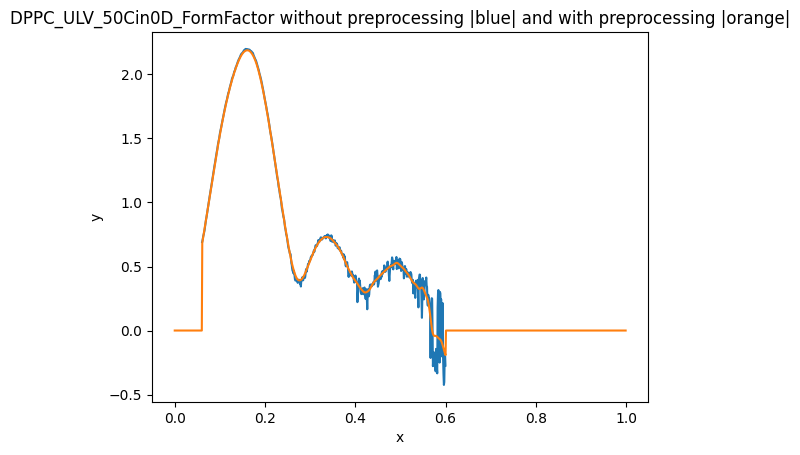

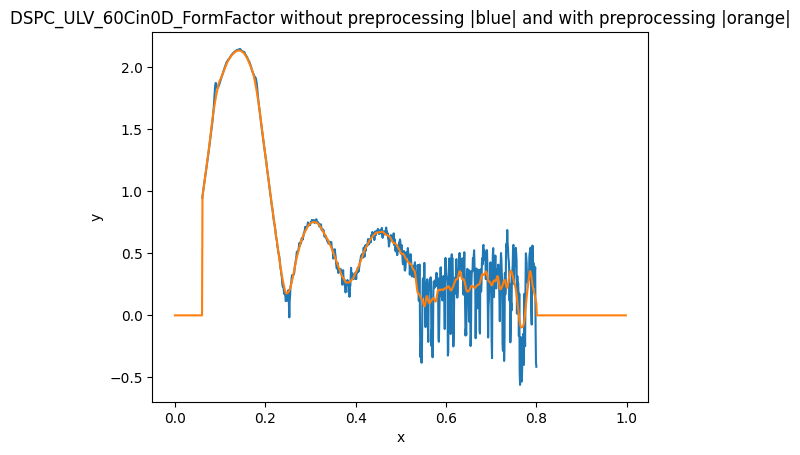

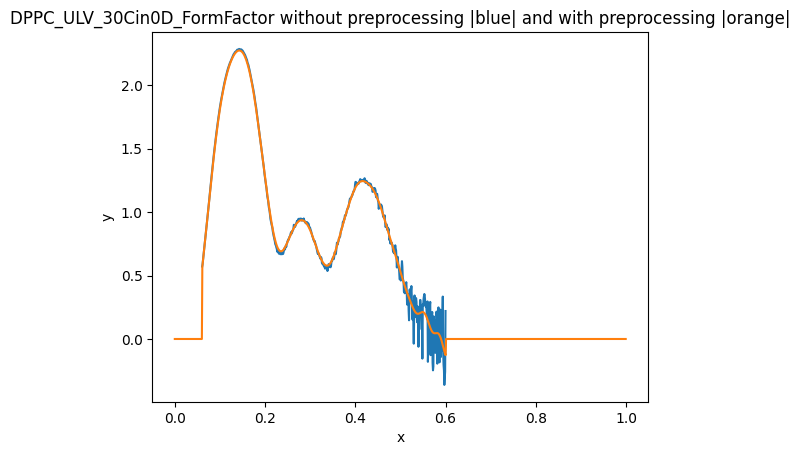

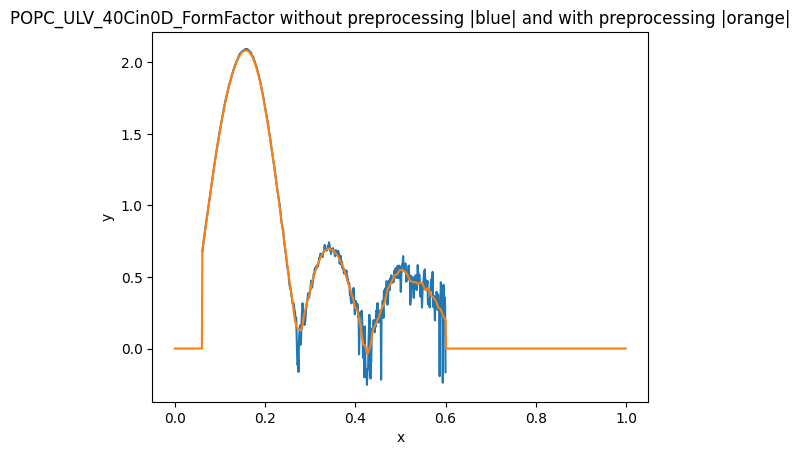

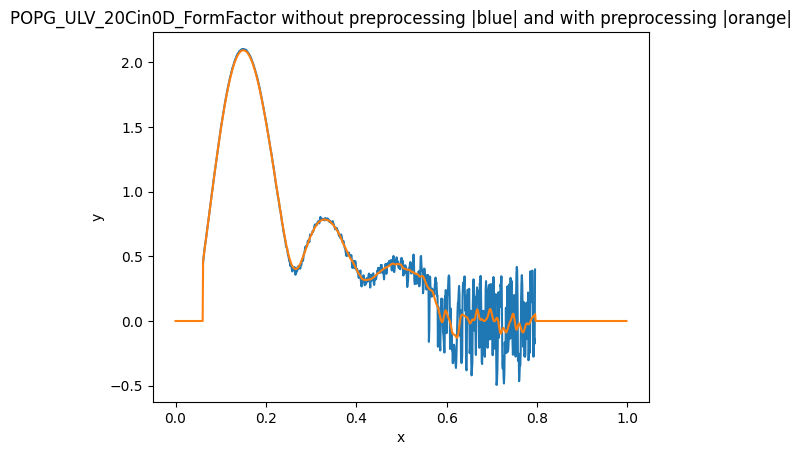

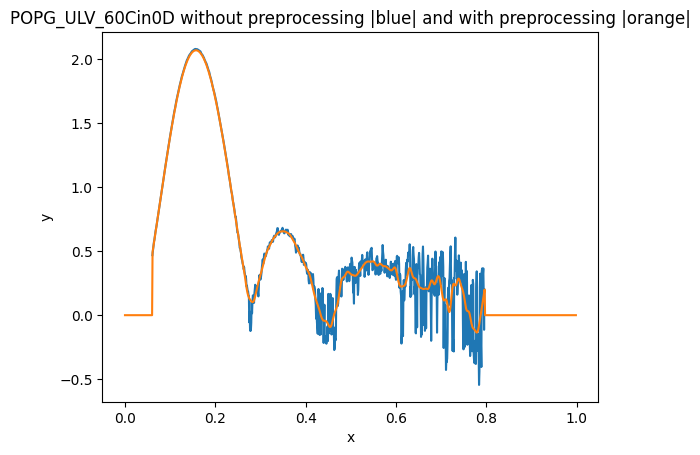

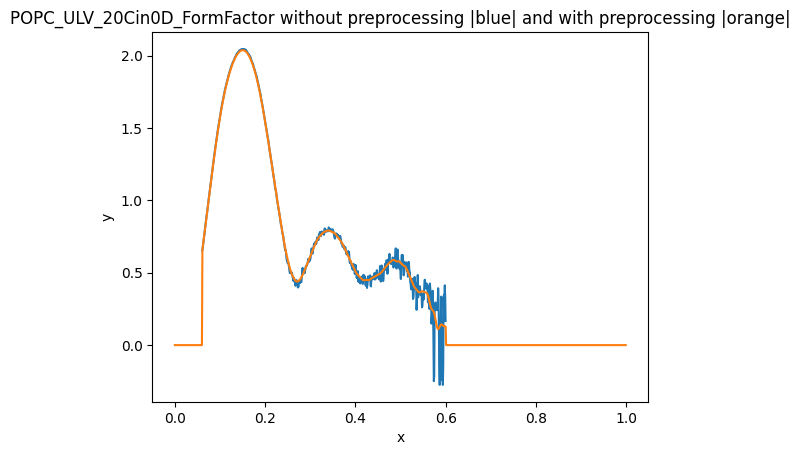

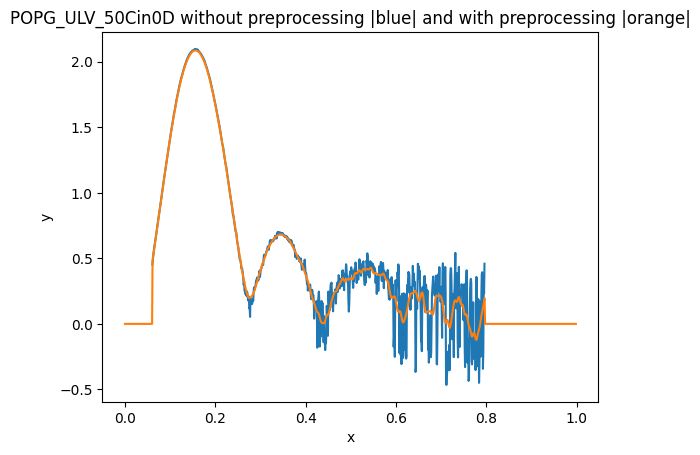

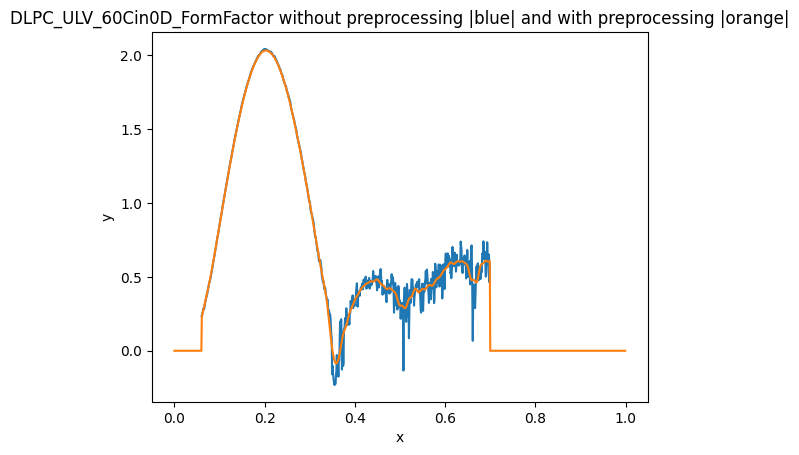

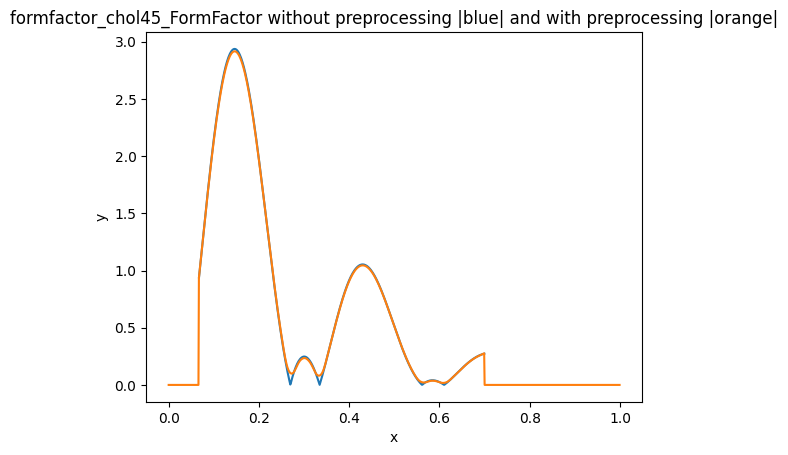

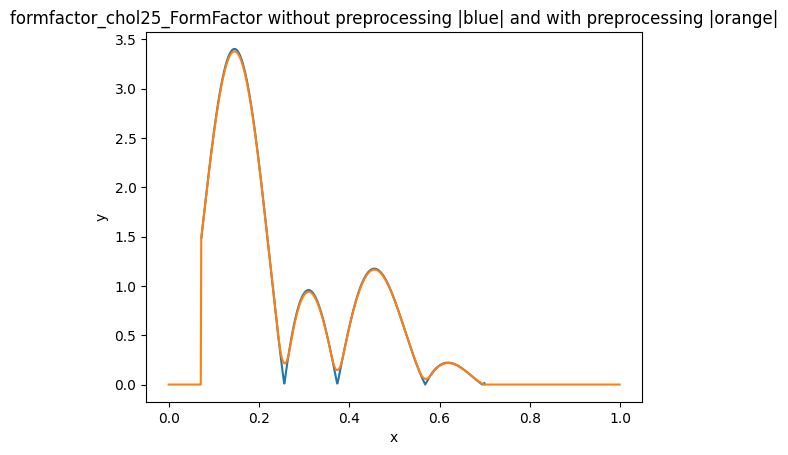

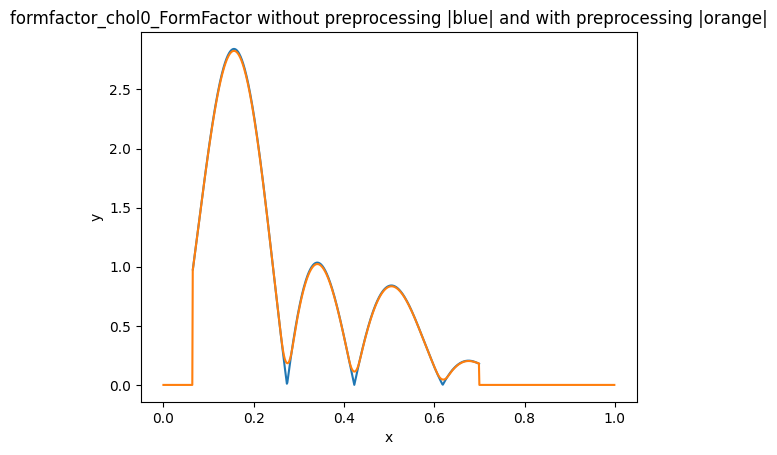

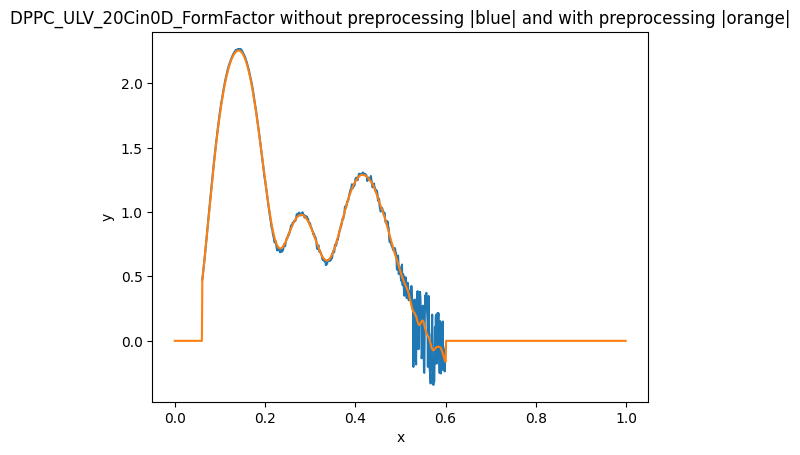

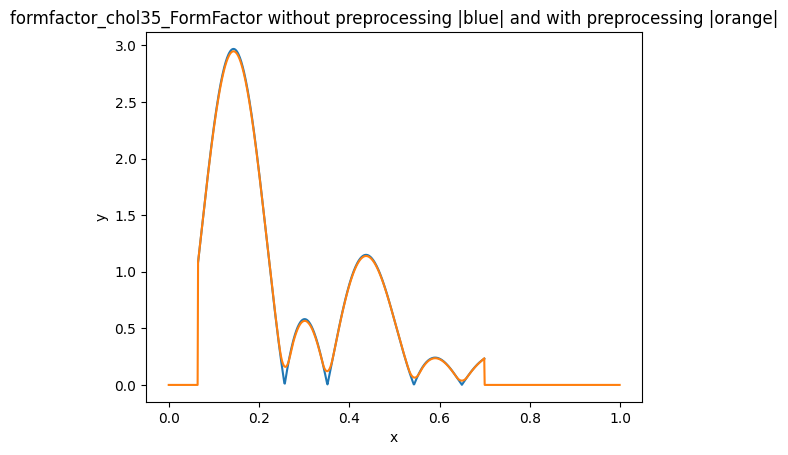

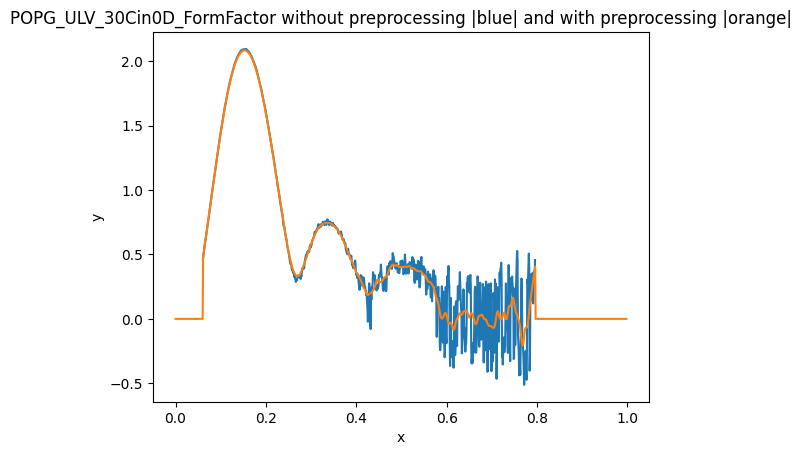

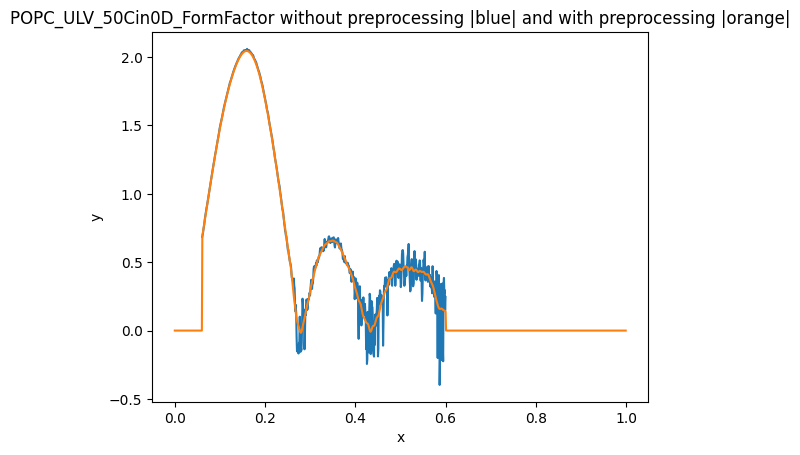

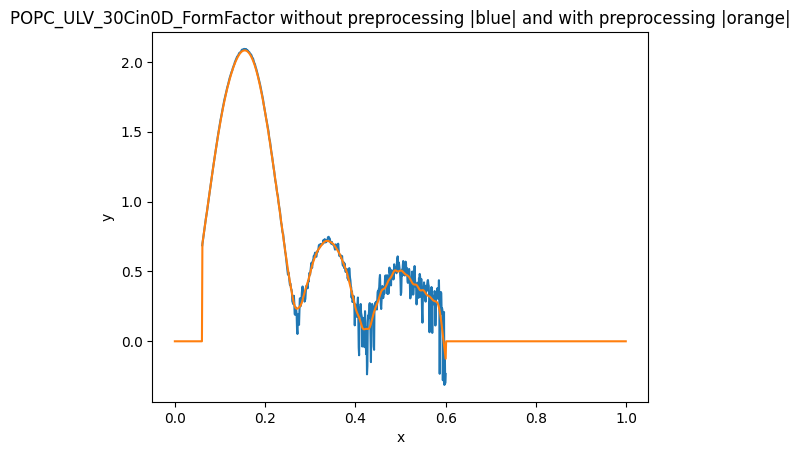

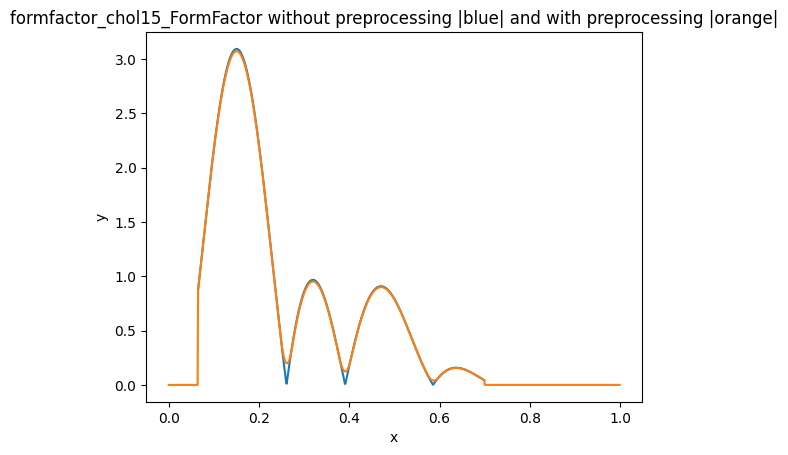

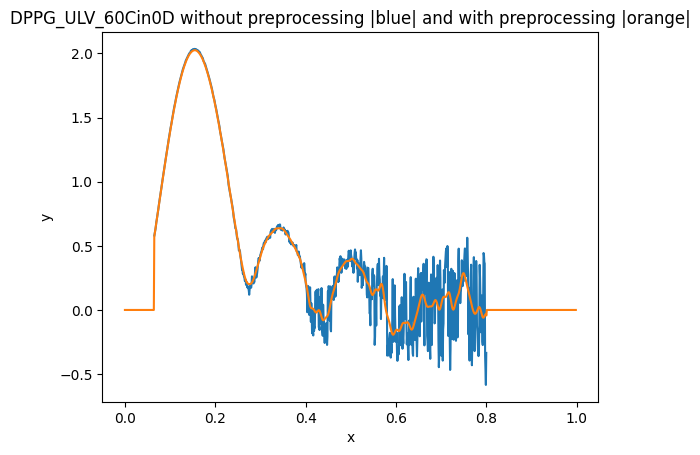

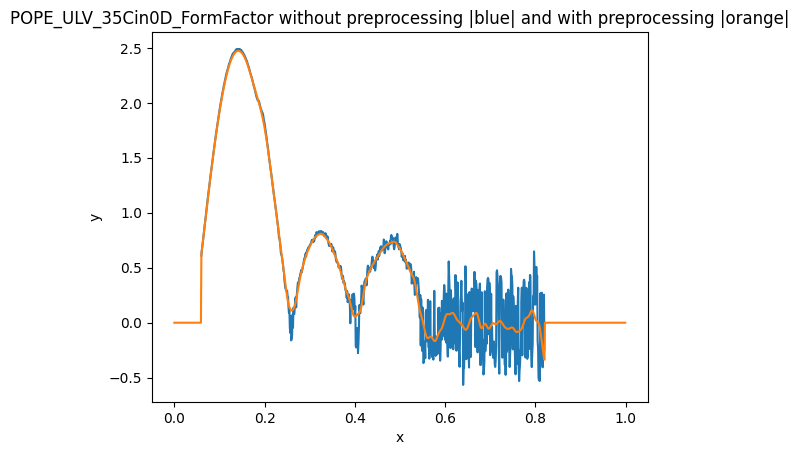

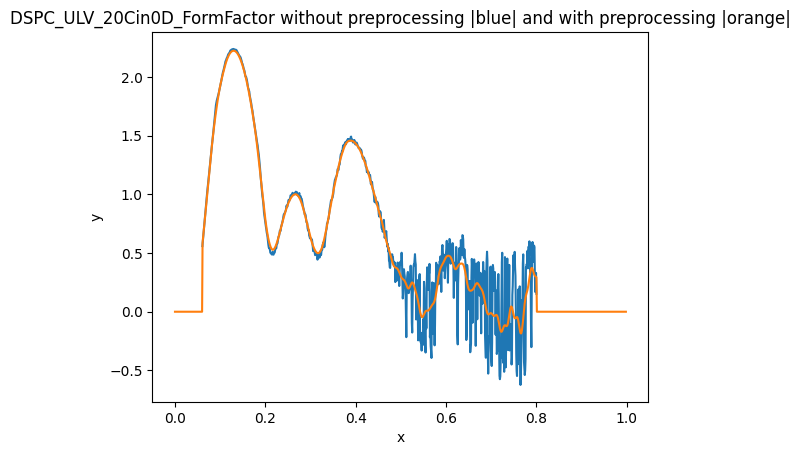

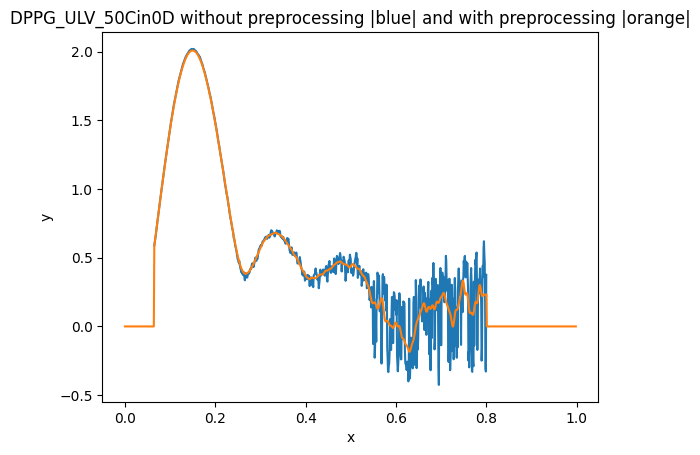

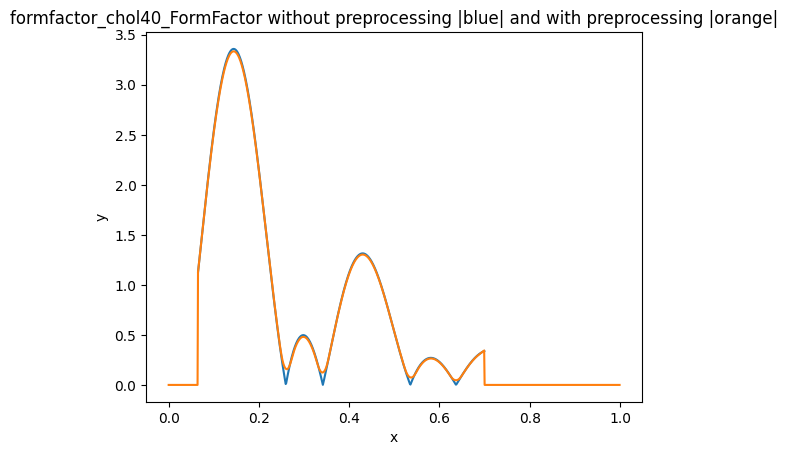

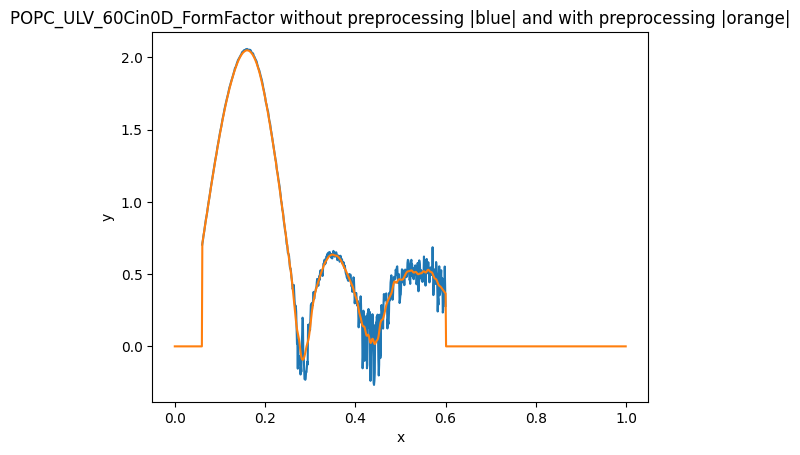

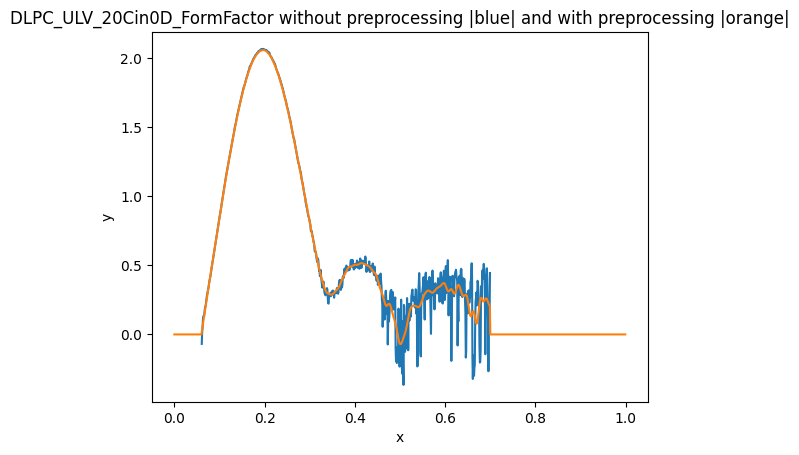

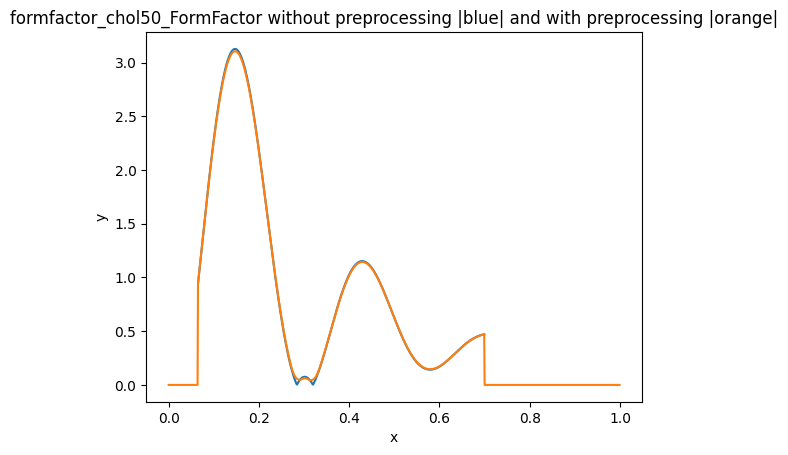

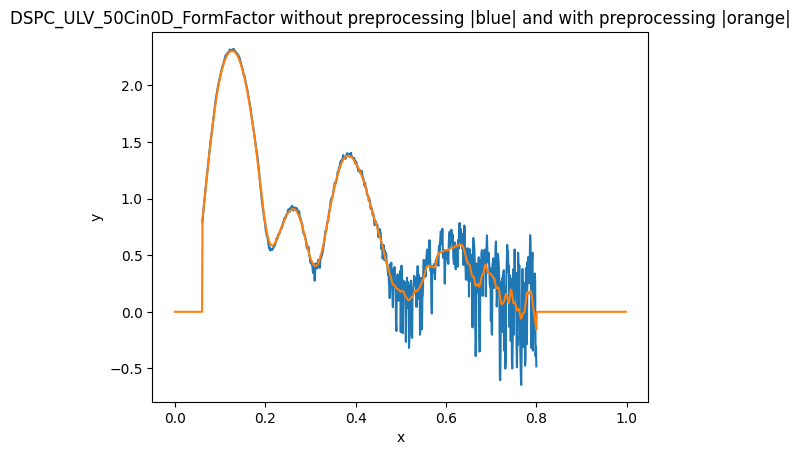

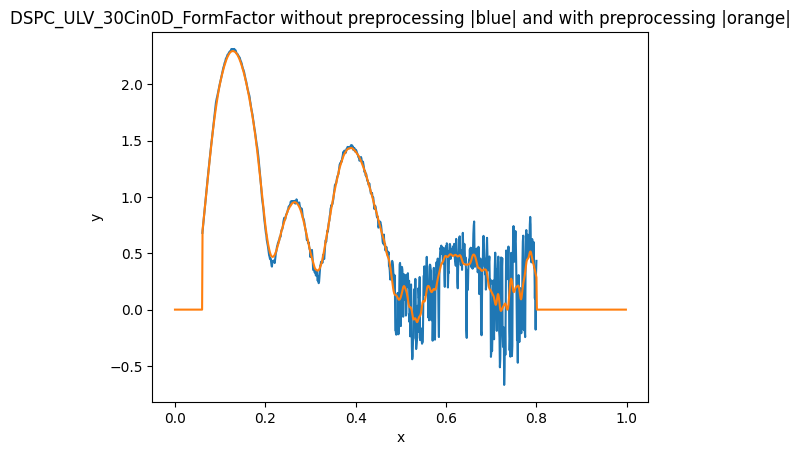

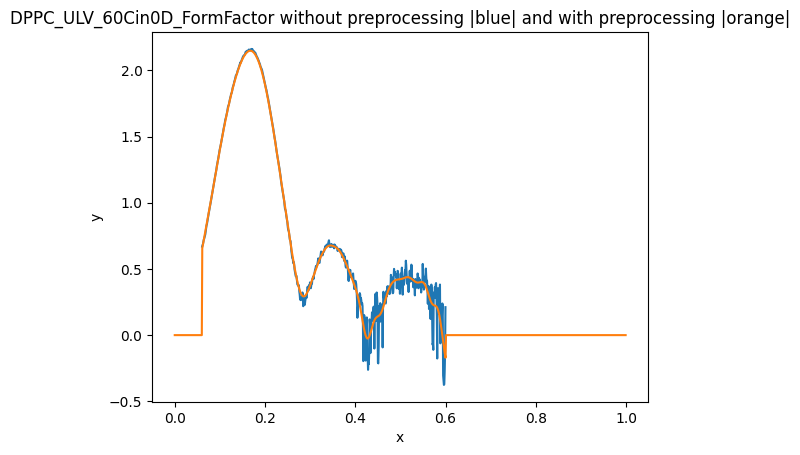

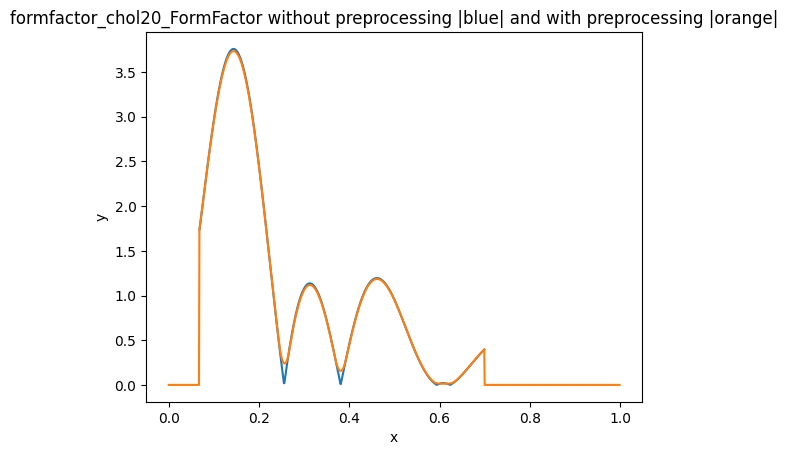

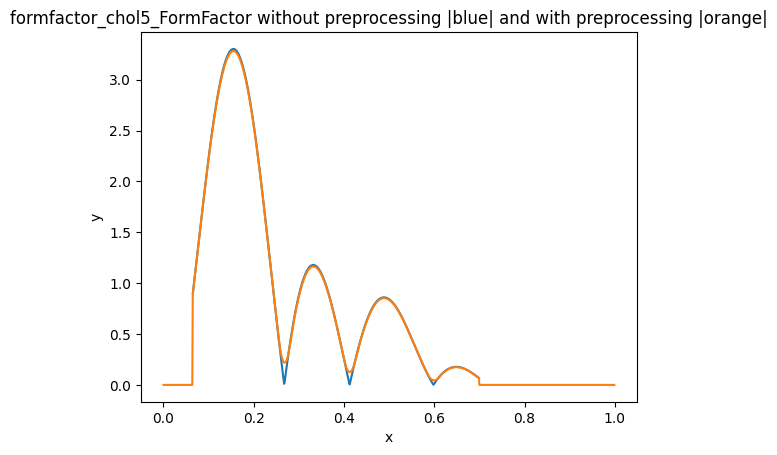

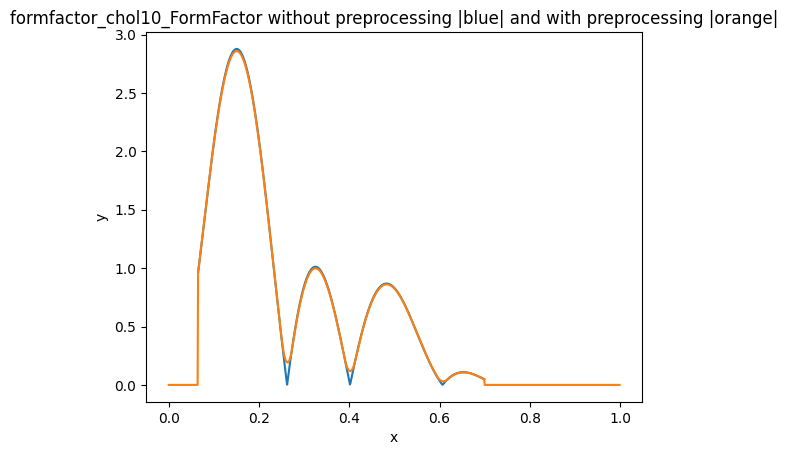

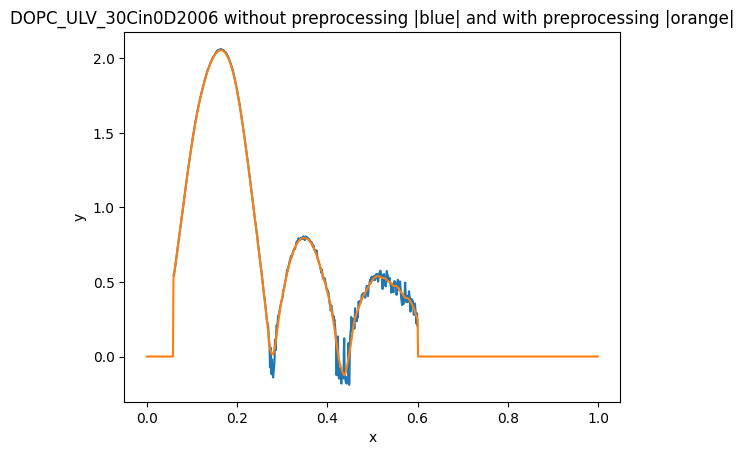

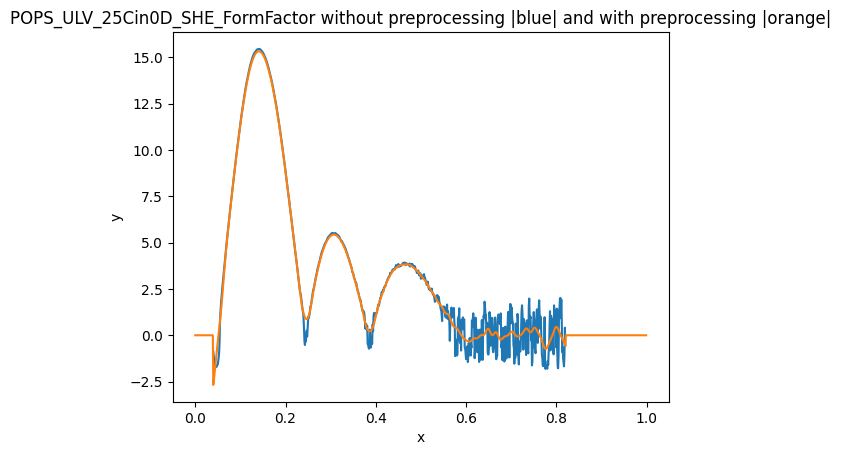

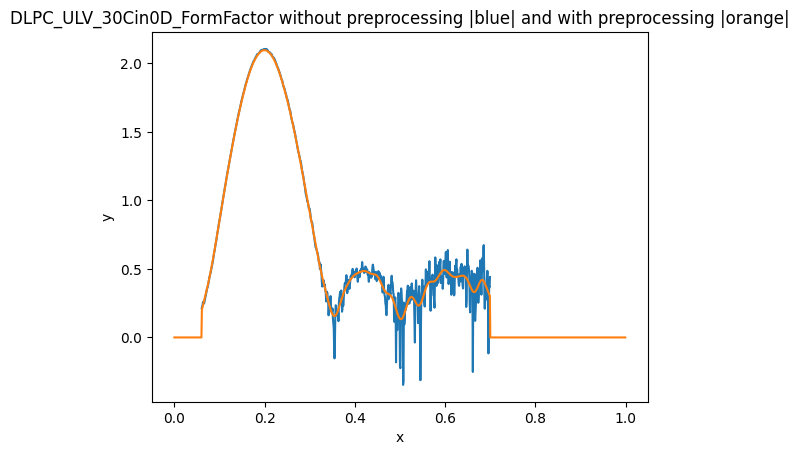

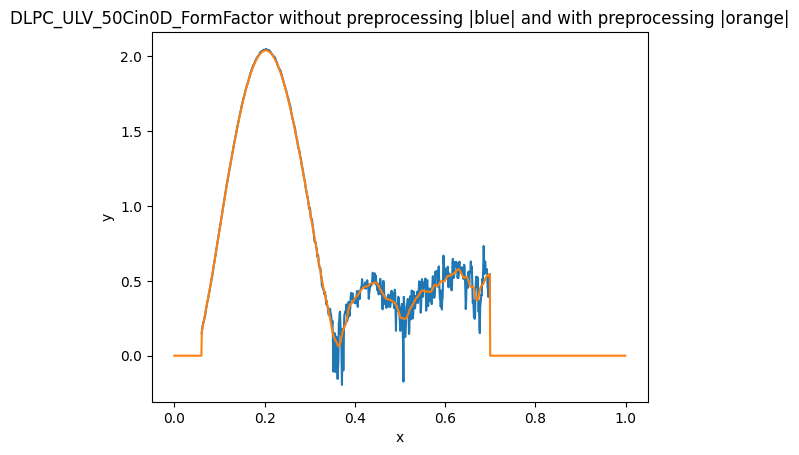

In [25]:
for index, column in enumerate(exp_FF.columns):
    plt.plot(exp_FF.iloc[0, index], exp_FF.iloc[1, index])
    plt.plot(np.arange(0, 1, 0.001), exp_FF_df[index])
    plt.title(column + ' without preprocessing |blue| and with preprocessing |orange|')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

Now we will randomly divide the available simulation data into training and test data, after which we will scale every case individually using their mean and standard diviation. The training amount of training data is set to be 80 % of available data, which in this case means 490 training input-output pairs and 123 test input-output pairs. Individual scaling upholds scale differences, while reducing the seen value ranges to make pattern seeking during training much easier. 

In [26]:
def reduced_FF_to_TD_preprocessing(exp_FF_df, sim_FF_df, sim_TD_x_df, sim_TD_y_df):
    random.seed(42)
    train = random.sample(list(sim_FF_df.columns),int(round(613*0.8,0)))
    test = []
    for number in list(sim_FF_df.columns):
        if not number in train:
            test.append(number)
    
    exp_FF_scaled_values = []
    for column in exp_FF_df.columns:
        exp_FF_scaled_values.append((exp_FF_df[column] - exp_FF_df[column].mean()) / exp_FF_df[column].std())
    
    exp_FF_scaled_df = pd.DataFrame(exp_FF_scaled_values)
    exp_FF_scaled_df = exp_FF_scaled_df.transpose()
    exp_FF_scaled_df.columns = exp_FF_df.columns
             
    FF_scaled_values = []
    for column in sim_FF_df.columns:
        FF_scaled_values.append((sim_FF_df[column] - sim_FF_df[column].mean()) / sim_FF_df[column].std())
    
    sim_FF_scaled_df = pd.DataFrame(FF_scaled_values)
    sim_FF_scaled_df = sim_FF_scaled_df.transpose()
    sim_FF_scaled_df.columns = sim_FF_df.columns
            
    sim_TD_x_df = sim_TD_x_df
    TD_x_scaled_values = []
    for column in sim_TD_x_df.columns:
        TD_x_scaled_values.append((sim_TD_x_df[column] - sim_TD_x_df[column].mean()) / sim_TD_x_df[column].std())
        
    TD_x_scaled_df = pd.DataFrame(TD_x_scaled_values)
    TD_x_scaled_df = TD_x_scaled_df.transpose()
    TD_x_scaled_df.columns = sim_TD_x_df.columns
    
    TD_y_scaled_values = []
    for column in sim_TD_y_df.columns:
        TD_y_scaled_values.append((sim_TD_y_df[column] - sim_TD_y_df[column].mean()) / sim_TD_y_df[column].std())
    
    TD_y_scaled_df = pd.DataFrame(TD_y_scaled_values)
    TD_y_scaled_df = TD_y_scaled_df.transpose()
    TD_y_scaled_df.columns = sim_TD_y_df.columns
    
    zeroing = round((TD_y_scaled_df.iloc[0]+TD_y_scaled_df.iloc[-1])/2,3)
    TD_y_scaled_df = TD_y_scaled_df.subtract(zeroing)
             
    sim_TD_df = pd.concat([TD_x_scaled_df, TD_y_scaled_df], axis=0)
    train_input = sim_FF_scaled_df[train].transpose().astype(np.float32)
    train_output = sim_TD_df[train].transpose().values.astype(np.float32)
    test_input = sim_FF_scaled_df[test].transpose().astype(np.float32)
    test_output = sim_TD_df[test].transpose().values.astype(np.float32)
    exp_input = exp_FF_scaled_df.transpose().values.astype(np.float32)
            
    print(train_input.shape)
    print(train_output.shape)
    print(test_input.shape)
    print(test_output.shape)
    print(exp_input.shape)
     
    return train_input, train_output, test_input, test_output, exp_input 

train_input, train_output, test_input, test_output, exp_input = reduced_FF_to_TD_preprocessing(exp_FF_df, sim_FF_df, sim_TD_x_df, sim_TD_y_df)

(490, 1000)
(490, 400)
(123, 1000)
(123, 400)
(36, 1000)


We can visualize the original and the resulted preprocessing data using this code block. As we can see, simulation FormFactors are much more uniform than simulation TotalDensities, which clearly have some outliers. These outliers will be kept for now, because we don't have any way of confirming correct shapes for TotalDensities predicted from experiment FormFactors, which is why decreasing the already small amount of data isn't smart. The experiment FormFactor themselves are quite similar to simulation FormFactors, but their shape varies much more in the end of the x-axis, which might affect the model a lot. 

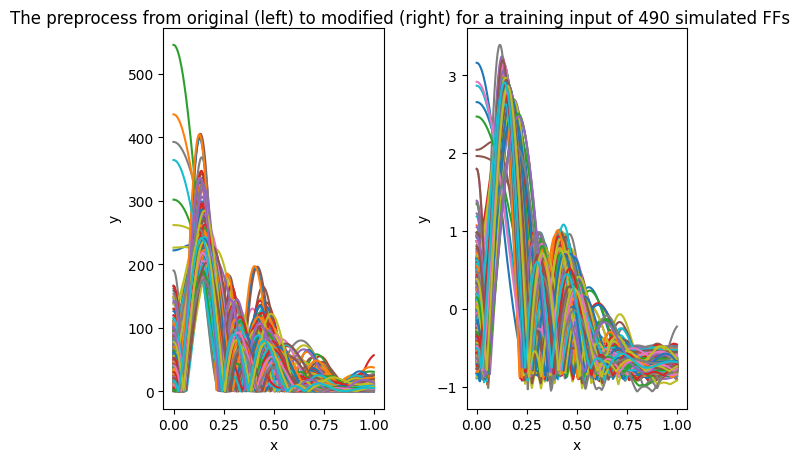

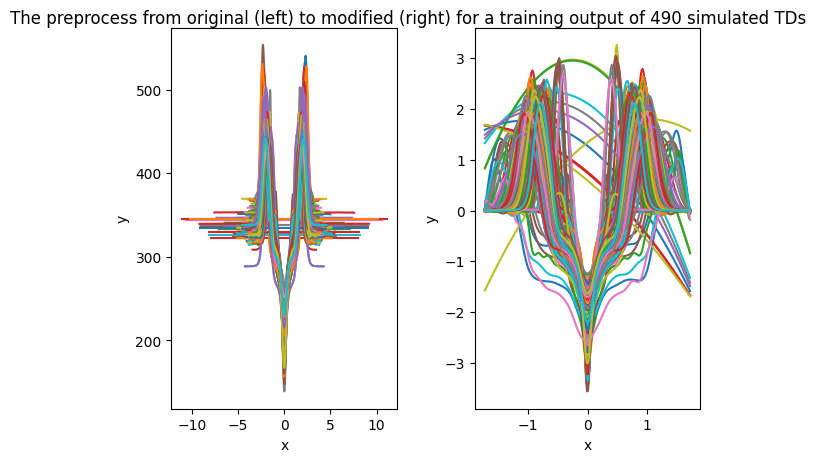

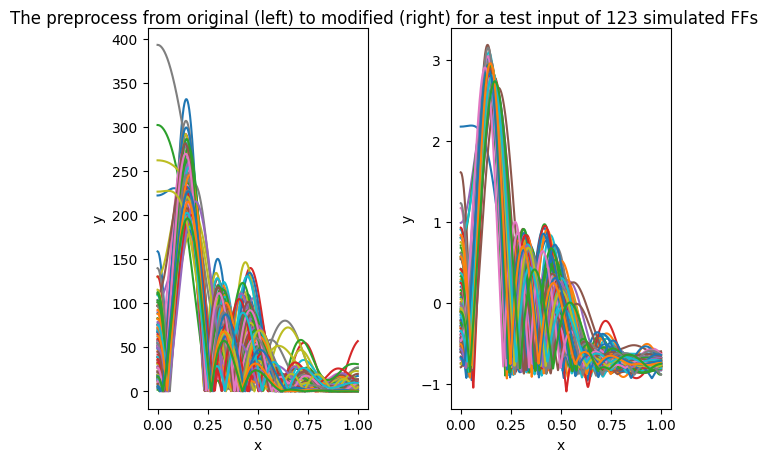

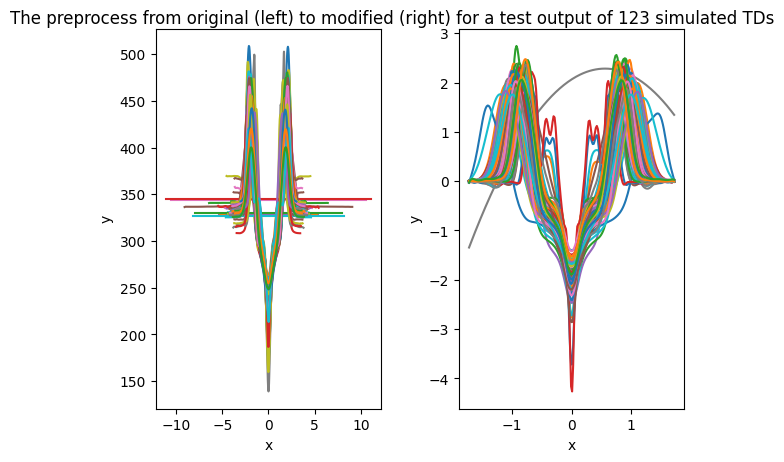

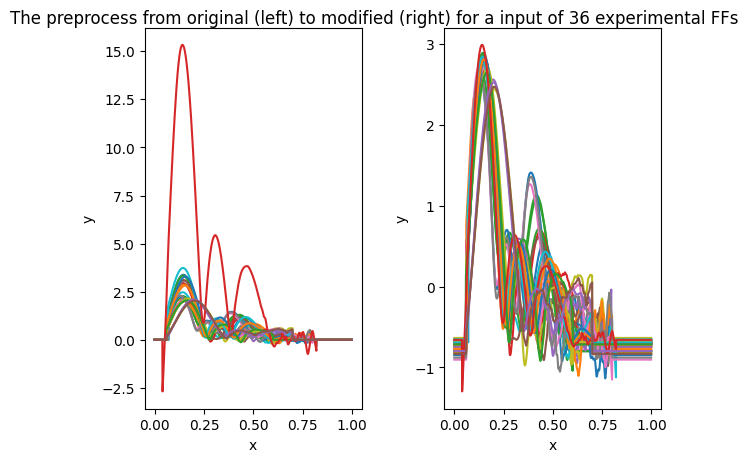

In [27]:
def data_plots(sim_FF_df, sim_TD_x_df, sim_TD_y_df, exp_FF, train_input, train_output, test_input, test_output, exp_input): 
    
    i = 0
    train_sim_FF_df = pd.DataFrame(train_input)
    columns = train_sim_FF_df.columns
    for row in train_sim_FF_df.iloc:
        plt.subplot(1,2,1)
        plt.plot(np.arange(0,1,0.001),sim_FF_df[int(columns[i])])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.subplot(1,2,2)
        plt.plot(np.arange(0,1,0.001),row)
        plt.xlabel('x')
        plt.ylabel('y')
        i = i + 1
    plt.tight_layout(pad=2.0)
    plt.suptitle('The preprocess from original (left) to modified (right) for a training input of ' + str(train_sim_FF_df.shape[0]) + ' simulated FFs')
    plt.show()
    
    i = 0
    train_sim_TD_df = pd.DataFrame(train_output)
    for row in train_sim_TD_df.iloc:
        plt.subplot(1,2,1)
        plt.plot(sim_TD_x_df[i],sim_TD_y_df[int(columns[i])])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.subplot(1,2,2)
        plt.plot(row[:200],row[200:])
        plt.xlabel('x')
        plt.ylabel('y')
        i = i + 1
    plt.tight_layout(pad=2.0)
    plt.suptitle('The preprocess from original (left) to modified (right) for a training output of ' + str(train_sim_TD_df.shape[0]) + ' simulated TDs')
    plt.show()
    
    i = 0
    test_sim_FF_df = pd.DataFrame(test_input)
    columns = test_sim_FF_df.columns
    for row in test_sim_FF_df.iloc:
        plt.subplot(1,2,1)
        plt.plot(np.arange(0,1,0.001),sim_FF_df[int(columns[i])])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.subplot(1,2,2)
        plt.plot(np.arange(0,1,0.001),row)
        plt.xlabel('x')
        plt.ylabel('y')
        i = i + 1
    plt.tight_layout(pad=2.0)
    plt.suptitle('The preprocess from original (left) to modified (right) for a test input of ' + str(test_sim_FF_df.shape[0]) + ' simulated FFs')
    plt.show()
    
    i = 0
    test_sim_TD_df = pd.DataFrame(test_output)
    for row in test_sim_TD_df.iloc:
        plt.subplot(1,2,1)
        plt.plot(sim_TD_x_df[i],sim_TD_y_df[int(columns[i])])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.subplot(1,2,2)
        plt.plot(row[:200],row[200:])
        plt.xlabel('x')
        plt.ylabel('y')
        i = i + 1
    plt.tight_layout(pad=2.0)
    plt.suptitle('The preprocess from original (left) to modified (right) for a test output of ' + str(test_sim_TD_df.shape[0]) + ' simulated TDs')
    plt.show()
    
    i = 0
    exp_FF_df = pd.DataFrame(exp_input)
    for row in exp_FF_df.iloc:
        plt.subplot(1,2,1)
        plt.plot(np.arange(0,1,0.001),exp_FF[i])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.subplot(1,2,2)
        plt.plot(np.arange(0,1,0.001),row)
        plt.xlabel('x')
        plt.ylabel('y')
        i = i + 1
    plt.tight_layout(pad=2.0)
    plt.suptitle('The preprocess from original (left) to modified (right) for a input of ' + str(exp_FF_df.shape[0]) + ' experimental FFs')
    plt.show()

data_plots(sim_FF_df, sim_TD_x_df, sim_TD_y_df, exp_FF_df,train_input, train_output, test_input, test_output, exp_input)

Here are different metrics and plotting functions for analysing the performance of the model. The used loss metric is mean squared error for data points (x,y), because it helps in comparing the score to the plots. The actual model currently isn't trained using this kind of loss, because it is less efficient and hurts accuracy, which is why mean absolute error is used instead.

In [28]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    sorted_loss = np.sort(loss_list)
    loss_quantile_50 = np.percentile(sorted_loss,50)
    loss_quantile_80 = np.percentile(sorted_loss,80)
    loss_quantile_95 = np.percentile(sorted_loss,95)
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for ' + str(amount) + ' cases')
    plt.show()
    
    return [average_loss, mode_loss, median_loss, loss_quantile_50, loss_quantile_80, loss_quantile_95]

def simulation_plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(actual)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = actual[number][0:length]
        y_2 = actual[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = actual[index][0:length].tolist()
        t_y = actual[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[0]][0:length]
    y_1 = prediction[train[0]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[0]][0:length]
    y_2 = actual[train[0]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[0]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[0]],prediction[train[0]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[4]][0:length]
    y_1 = prediction[train[4]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[4]][0:length]
    y_2 = actual[train[4]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[4]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[4]],prediction[train[4]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[9]][0:length]
    y_1 = prediction[train[9]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[9]][0:length]
    y_2 = actual[train[9]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[9]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[9]],prediction[train[9]])))
    
def experiment_predictions(exp_input,prediction):
    random.seed(42)
    train = random.sample(range(0,len(prediction)),10)
    length = int(len(prediction[0])/2)
    for number in train:
        plt.subplot(1,2,1)
        plt.plot(np.arange(0,1,0.001), exp_input[number])
        plt.subplot(1,2,2)
        plt.plot(prediction[number][0:length],prediction[number][length:])
        plt.suptitle('TD prediction for experiment FF index ' + str(number))
        plt.show()
        
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b')
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction on experiment data')
    plt.show()
    
def predicted_plot(prediction):
    prediction = prediction.reshape(400,1)
    length = int(prediction.shape[0]/2)
    plt.plot(prediction[0:length],prediction[length:])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Predicted TotalDensity for the given FormFactor')
    plt.show()

Here we use available metrics to analyse the model performance on training data. As expected for training data, the shown results are pretty good since the average loss is 0.093, most frequent case is 0.029, median is 0.045, 80th quantile is 0.10 and 95th quantile is 0.311, which make the loss frequency generally approximate a power law and in the 0.0-0.10 range a normal distribution with the highest point being around 0.08 with 34 cases. However, these results should only be used for verification purposes regarding the success of the learning process and nothing else, becase the model will not encounter data that will be completly similar to the training data.

16/16 [==============================] - 0s 8ms/step


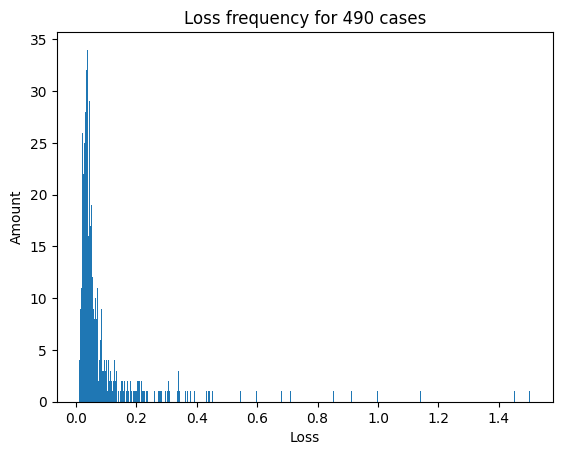

Loss average is: 0.09306952290807467
Loss mode is: [(0.02946, 3), (0.02312, 2), (0.03541, 2), (0.0513, 2), (0.03369, 2), (0.03653, 2), (0.05046, 2), (0.02524, 2), (0.02317, 2), (0.04292, 2)]
Loss median is: 0.04597
Loss 80th quantile: 0.10167934194194775
Loss 95th quantile: 0.31168083077079456
16/16 [==============================] - 0s 7ms/step


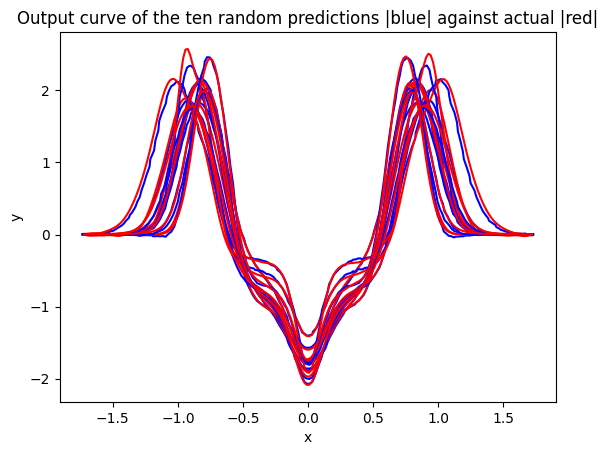

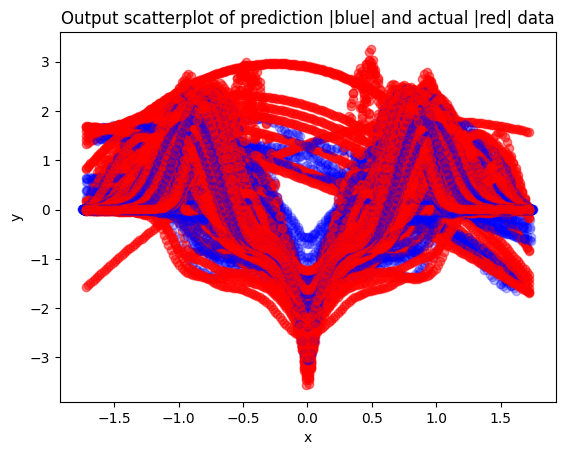

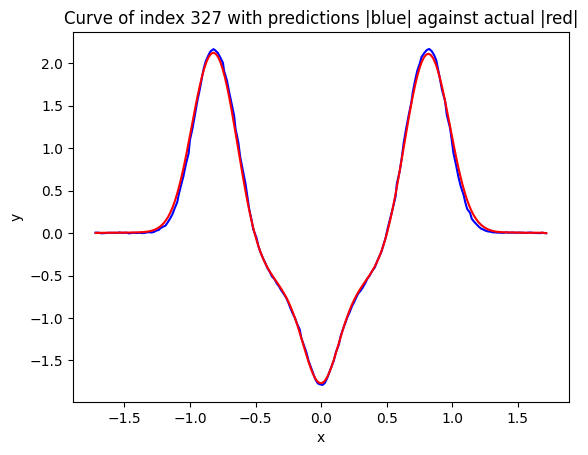

The loss of the curve 0.03368745452642802


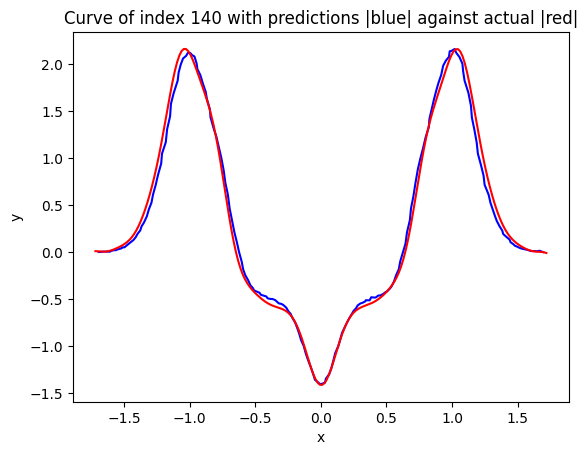

The loss of the curve 0.04287684363137242


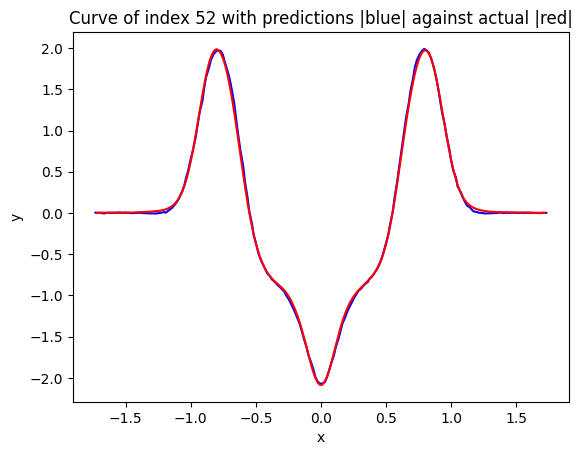

The loss of the curve 0.03430826643645533


In [29]:
results = metrics(train_output, model.predict(train_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(train_output,model.predict(train_input))

Here we use available metrics to analyse the model performance on testing data. The shown results are again quite good, since the average loss is 0.166, there is no mode,  median is 0.097, 80th quantile is 0.249 and 95th quantile is 0.490, which again make the loss frequency generally approximate a power law and in the 0.0-0.10 range a normal distribution with the highest point being around 0.04 with 16 cases. These results show that the model is quite able to generalize with respectable accuracy to unseen simulation data, which again confirms the learning process being valid. However, they also show that the model will possibly never have a perfect accuracy due to the model approximating a local normal distribution with a generalized power law. 

4/4 [==============================] - 0s 7ms/step


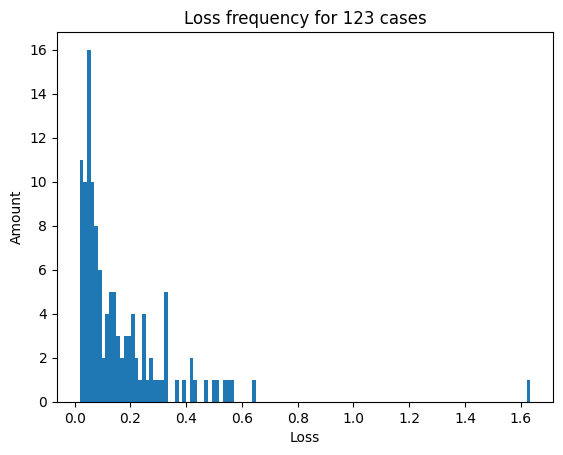

Loss average is: 0.16668343430624896
Loss mode is: [(0.13529, 1), (0.413, 1), (0.13727, 1), (0.20219, 1), (0.46774, 1), (0.09059, 1), (0.39113, 1), (1.63504, 1), (0.14832, 1), (0.08262, 1)]
Loss median is: 0.09789
Loss 80th quantile: 0.2495235663400239
Loss 95th quantile: 0.4905994927809182
4/4 [==============================] - 0s 7ms/step


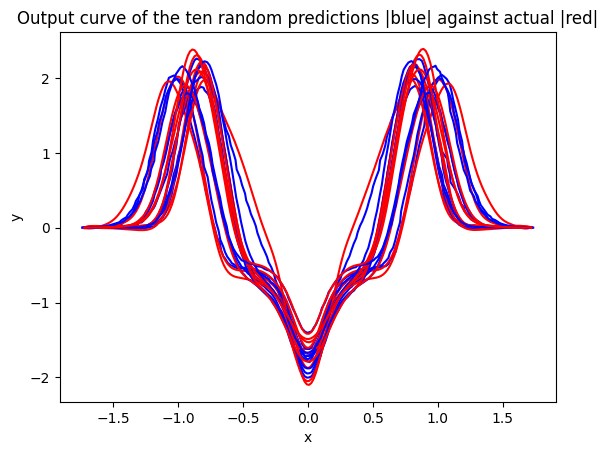

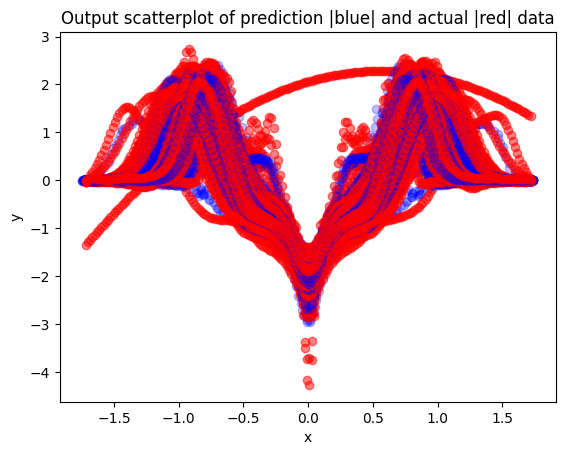

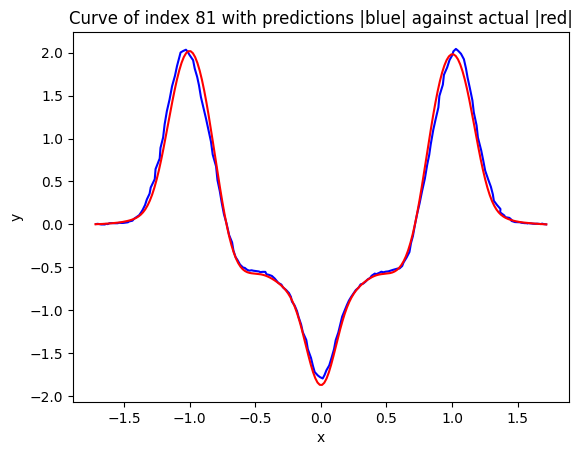

The loss of the curve 0.054815505225163014


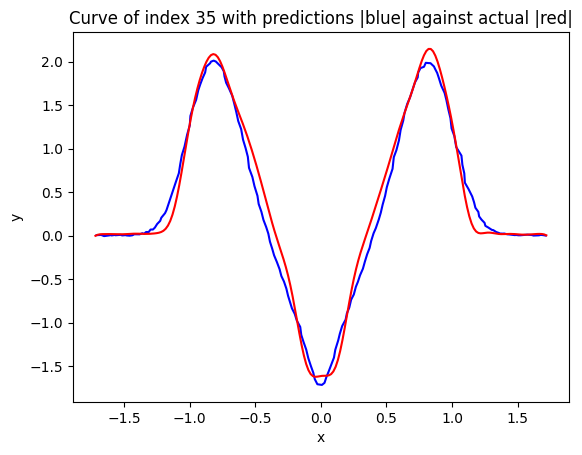

The loss of the curve 0.11992844969755073


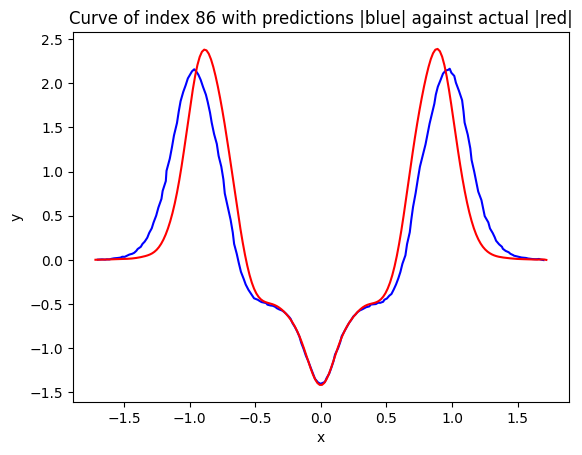

The loss of the curve 0.28786575963118854


In [30]:
results = metrics(test_output, model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))

Here we plot the experiment FormFactor and predicted TotalDensity pairs. As we can see, all of the TotalDensities have the same smooth shape, but their width and height do vary. This shows the model capable of predicting for experimental data, but since we have no data regarding their actual TotalDensities, we can only guess their validity. One intuitive guess based on minima and maxima analysis on simulated FormFactor and TotalDensity pairs says that there should be a bit more variety in different shapes, but due to lacking background regarding the process creating these pairs this cannot be confirmed in any way.

2/2 [==============================] - 0s 6ms/step


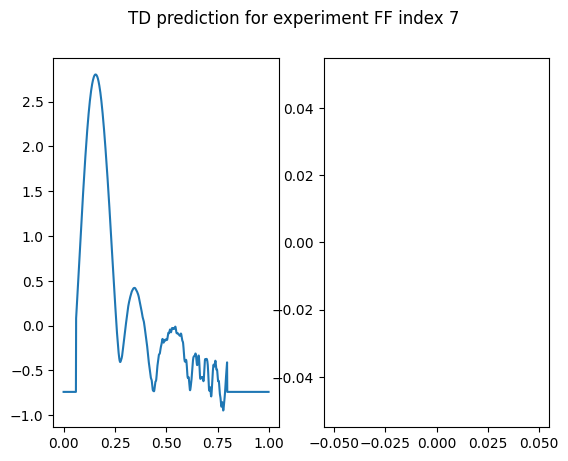

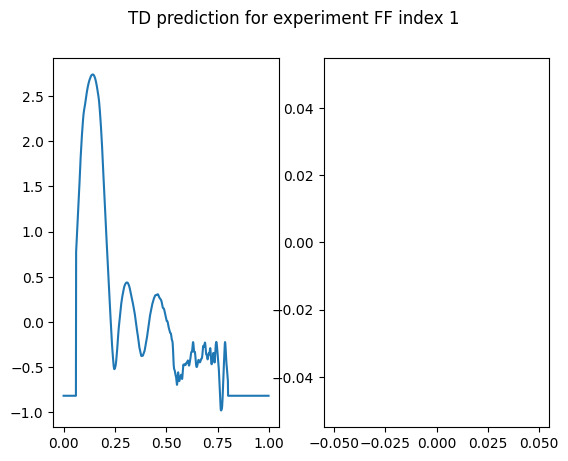

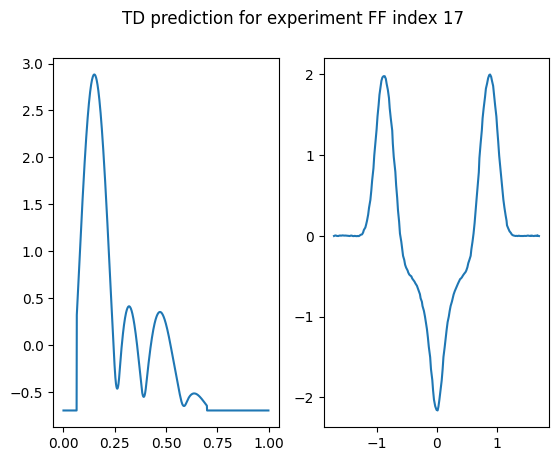

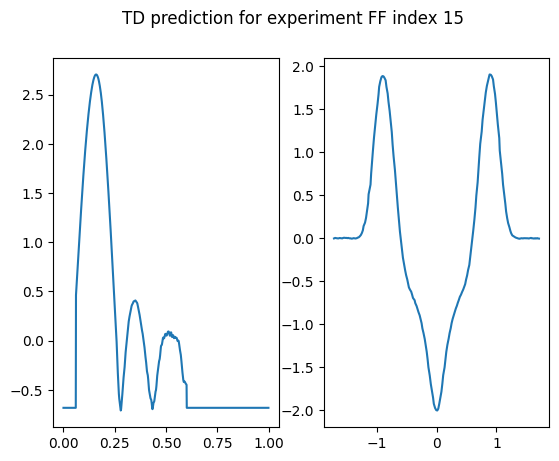

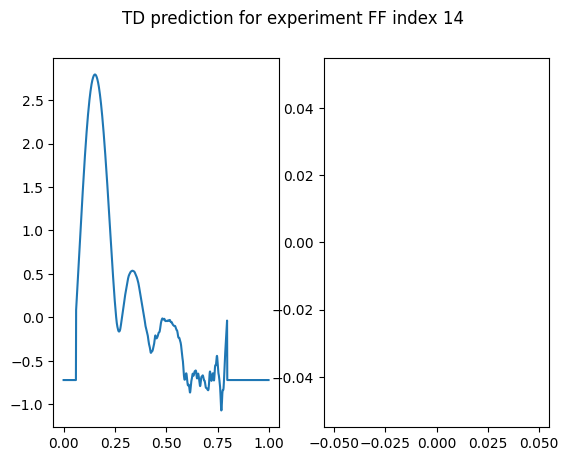

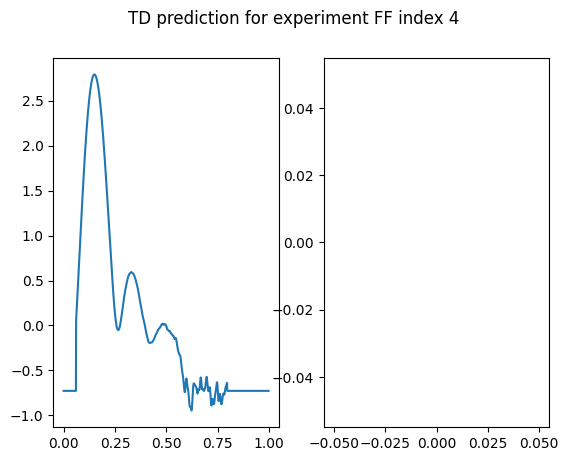

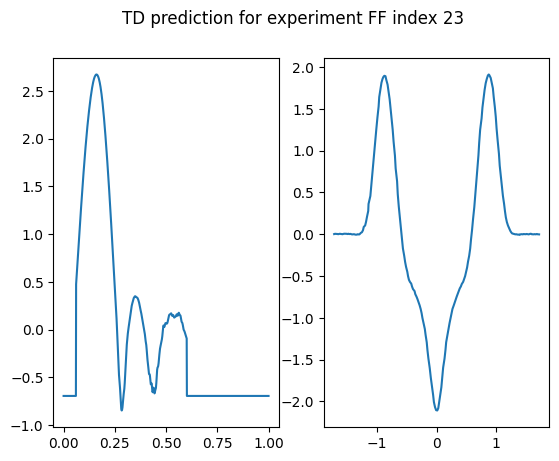

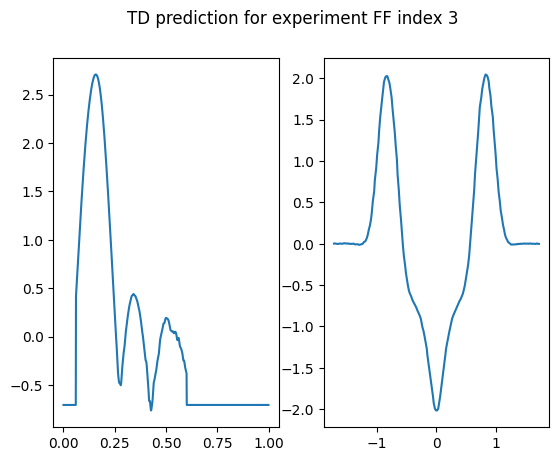

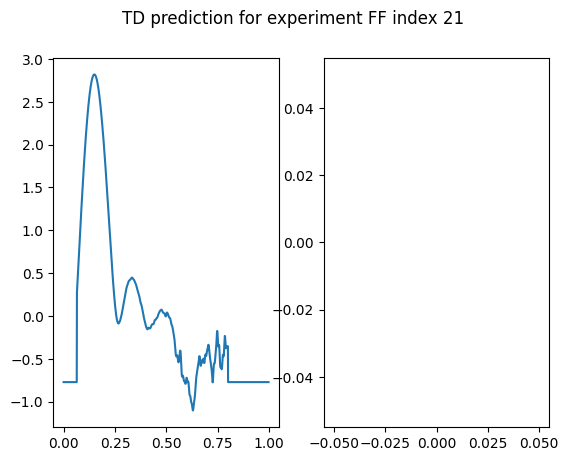

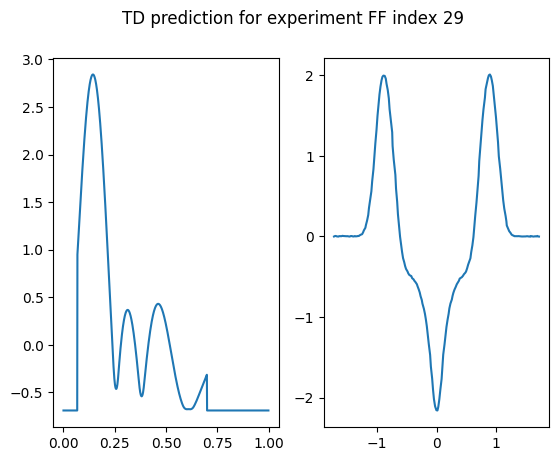

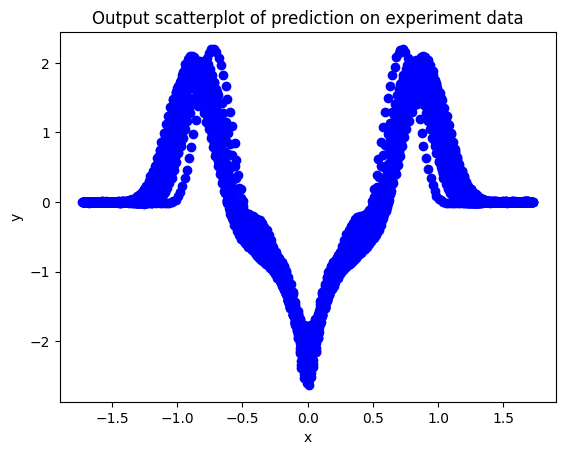

In [32]:
experiment_predictions(exp_input,model.predict(exp_input))

Finally, we will go through these two last block used for getting a TotalDensity prediction to a new experiment FormFactor not seen in the available data. The recommended format for this kind of data is either .csv or .json, because they can be easily put into a pandas dataframe for easier manipulation.

In [33]:
exp_FF = pd.read_json('experiment_formfactors.json')

In [34]:
exp_FF

DPPC_ULV_50Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.69045, 0.7043900000000001, 0.72295000000000...   

                         DSPC_ULV_60Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.9479900000000001, 0.9762600000000001, 1.001...   

                         DPPC_ULV_30Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.5710900000000001, 0.5901000000000001, 0.621...   

                         POPC_ULV_40Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.6769200000000001, 0.68742, 0.70990000000000...   

                         POPG_ULV_20Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.44433000000000006, 0.4756, 0.50405, 0.53155...   

                                    POPG_ULV_60Cin0D   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.46873000000000004, 0.49742000000000003, 0.5...   

                         POPC_ULV_20Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.6531100000000001, 0.66791, 0.69012000000000...   

                                    POPG_ULV_50Cin0D   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.45304000000000005, 0.48837, 0.51829, 0.5459...   

                         DLPC_ULV_60Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.23598000000000002, 0.24655000000000002, 0.2...   

                        formfactor_chol45_FormFactor  ...   
0  [0.06722349999999999, 0.0682397, 0.0692559, 0....  ...  \
1  [0.9408137999999999, 0.9802428, 1.019736, 1.05...  ...   

                         DSPC_ULV_50Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.7949600000000001, 0.8243100000000001, 0.869...   

                         DSPC_ULV_30Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.6812, 0.7182900000000001, 0.75839, 0.79412,...   

                         DPPC_ULV_60Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.66807, 0.6795, 0.6863300000000001, 0.70381,...   

                        formfactor_chol20_FormFactor   
0  [0.0682397, 0.0692559, 0.07027209999999999, 0....  \
1  [1.738367, 1.779776, 1.82124, 1.862742, 1.9042...   

                         formfactor_chol5_FormFactor   
0  [0.0651909, 0.06620709999999999, 0.06722349999...  \
1  [0.8994512, 0.9382140999999999, 0.9771616, 1.0...   

                        formfactor_chol10_FormFactor   
0  [0.0651909, 0.06620709999999999, 0.06722349999...  \
1  [0.9649669999999999, 0.9978982999999999, 1.030...   

                                DOPC_ULV_30Cin0D2006   
0  [0.059300000000000005, 0.06008, 0.060870000000...  \
1  [0.5454300000000001, 0.54396, 0.5572, 0.57532,...   

                     POPS_ULV_25Cin0D_SHE_FormFactor   
0  [0.04, 0.041, 0.042, 0.043000000000000003, 0.0...  \
1  [-0.8847, -1.133, -1.3247, -1.4694, -1.54, -1....   

                         DLPC_ULV_30Cin0D_FormFactor   
0  [0.060700000000000004, 0.06158, 0.062460000000...  \
1  [0.21422000000000002, 0.2235, 0.23718000000000...   

                         DLPC_ULV_50Cin0D_FormFactor  
0  [0.060700000000000004, 0.06158, 0.062460000000...  
1  [0.14883000000000002, 0.17136, 0.1944000000000...  

[2 rows x 36 columns]

The following function does the required preprocess for a single experimental FormFactor case by using its x-axis values and y-axis values. When the preprocessing is done, the saved variable can be predicted_plot() function to plot it. Be aware that since the model input is (none, 1000), the variable data needs to be transformed using reshape(-1,1000) function.

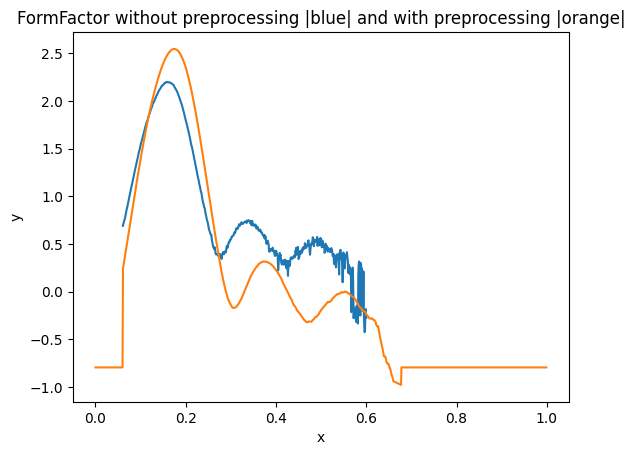

1/1 [==============================] - 0s 23ms/step


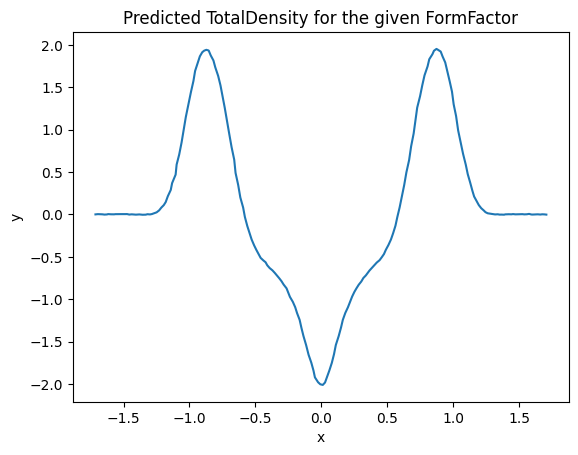

In [35]:
def single_experiment_FF_preprocess(x_axis_list,y_axis_list):
    special = False
    x_start = round(x_axis_list[0],4)
    x_end = round(x_axis_list[-1],4)
    front_zeros = int(round(x_start/0.001))
    
    if front_zeros == 0:
        special = True
        x_start = round(exp_FF.iloc[0,i][1],4)
        front_zeros = int(round(x_start/0.001))
        
    denoising = savgol_filter(y_axis_list,35,1)
    
    if special:
        front_padding = np.concatenate((np.zeros(front_zeros-1), denoising))
        back_padding = np.concatenate((front_padding, np.zeros(1000 - len(front_padding))))
        scaling = (back_padding-np.mean(back_padding))/np.std(back_padding)
        
        plt.plot(x_axis_list,y_axis_list)
        plt.plot(np.arange(0,1,0.001),scaling)
        plt.title('FormFactor without preprocessing |blue| and with preprocessing |orange|')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        
        return scaling
    
    front_padding = np.concatenate((np.zeros(front_zeros), denoising))
    back_padding = np.concatenate((front_padding, np.zeros(1000 - len(front_padding))))
    scaling = (back_padding-np.mean(back_padding))/np.std(back_padding)
    
    plt.plot(x_axis_list,y_axis_list)
    plt.plot(np.arange(0,1,0.001),scaling)
    plt.title('FormFactor without preprocessing |blue| and with preprocessing |orange|')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    return scaling
    
x = exp_FF.iloc[0,0]
y = exp_FF.iloc[1,0]
Experiment_FF = single_experiment_FF_preprocess(x,y)
predicted_plot(model.predict(Experiment_FF.reshape((-1, 1000))))